# Import

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import OneHotEncoder

C:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from xgboost import XGBRegressor

In [4]:
from catboost import CatBoostRegressor, CatBoost

# Data upload

## restautants.csv

Загрузим файл restaurants.csv и посмотрим на данные. Думаю очевидно, что это простая табличка содержащая id города в котором есть ресторан данной сети, а количество жителей в нем (либо что-то эквивалентное по описательному смыслу).
Городов всего 20 (это указано в условиях), а size (видимо кол-во жителей) в диапазоне от 37 до 205 тысяч.
 - Пропуски значений отстутсвуют
 - Повторений в столбце Size также нет, что говорит о уникальности городов
 - Видим что население городов иногда очень близки, что можно рассматривать как категориальный признак.

In [5]:
cities = pd.read_csv('restaurants.csv')
cities

,City,Size
0,1,151315
1,2,202307
2,3,37392
3,4,205863
4,5,34875
5,6,202505
6,7,70713
7,8,155078
8,9,125833
9,10,126512


In [6]:
cities.describe()

,City,Size
count,20.00000,20.000000
mean,10.50000,142749.300000
std,5.91608,61683.245197
min,1.00000,34875.000000
25%,5.75000,107475.500000
50%,10.50000,138913.500000
75%,15.25000,202814.250000
max,20.00000,219622.000000


In [7]:
# проверяем не повторяются ли значения size
cities.Size.nunique()

20

In [8]:
# сортируем значения
cities.Size.sort_values()

4      34875
2      37392
15     57197
6      70713
16     93188
11    112238
17    120653
14    123737
8     125833
9     126512
0     151315
7     155078
13    200898
1     202307
5     202505
19    203742
18    203819
3     205863
10    207499
12    219622
Name: Size, dtype: int64

## data.csv

Загрузим файл data.csv и детальнее посмотрим на признаки. Также видим что кол-во городов совпадает с restaurant.csv. 

- Кол-во записей по городам одинаково, т.е. пропусков не было за весь период.
- Температура имеет большие значение (от -7 до 101), видимо измерена в Фарингейтах. В Цельсиях диапазон значений будет (от -21 до 38). Переводить пока что не имеет смысла, т.к. в данной системе исчеслений значения имеют больший диапазон.
- Цены на топливо занимают довольно узкий диапозон (25 и 75 процентили меньше чем +-std от мат. ожидания). На графике распределения данного признака хорошо видно 2 вершины.
- Уровень безработицы имеет 7% пропусков на данных.
- Дата разбита по неделям, видим что 2011 и 2012 годы имеют одинаковое кол-во значений. 2010 немного меньше - отсутствуют 3 недели по 20 городов в каждой (итогово 60 зачений). А 2013 год не полный (чуть больше половины). Но т.к. мы предсказываем только 2012 год, то этого достаточно.
- Корреляции между признаками температура, стоимость топлива и безработицей отсутствует (что вполне логично и даже очевидно). Но зависимость необходимо было проверить на случай использования линейных моделей.

С природой данных познакомились, все признаки довольно общие и не учитывают каких-то более локальных характеристик как расположение ресторана, время его работы, цен в меню, выбор блюд и прочее.

In [9]:
data = pd.read_csv('data.csv')
data

,City,Date,Temperature,Fuel_Price,Unemployment,IsHoliday
0,1,05-02-10,42.31,2.572,8.106,False
1,1,12-02-10,38.51,2.548,8.106,True
2,1,19-02-10,39.93,2.514,8.106,False
3,1,26-02-10,46.63,2.561,8.106,False
4,1,05-03-10,46.50,2.625,8.106,False
...,...,...,...,...,...,...
3635,20,28-06-13,74.02,3.639,NaN,False
3636,20,05-07-13,72.97,3.614,NaN,False
3637,20,12-07-13,72.59,3.614,NaN,False
3638,20,19-07-13,77.50,3.737,NaN,False


In [10]:
data.describe()

,City,Temperature,Fuel_Price,Unemployment
count,3640.000000,3640.000000,3640.000000,3380.000000
mean,10.500000,59.166354,3.378593,7.414191
std,5.767074,18.788846,0.427207,1.678688
min,1.000000,-7.290000,2.514000,3.879000
25%,5.750000,45.872500,3.015500,6.380000
50%,10.500000,60.640000,3.479000,7.290000
75%,15.250000,73.967500,3.707500,8.106000
max,20.000000,101.950000,4.468000,14.313000


In [11]:
# кол-во записей по городам
data.City.value_counts()

19    182
17    182
4     182
6     182
8     182
10    182
12    182
14    182
16    182
18    182
20    182
1     182
3     182
5     182
7     182
9     182
11    182
13    182
15    182
2     182
Name: City, dtype: int64

In [12]:
data.Date.nunique()

182

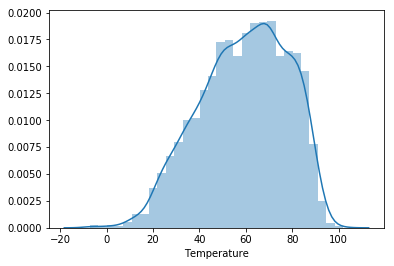

In [13]:
# распределение температуры
sns.distplot(data.Temperature)

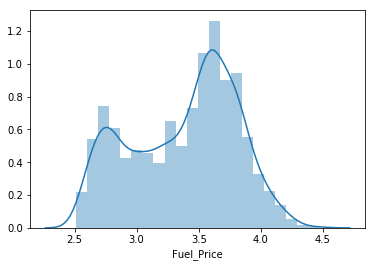

In [14]:
# распределение цен на топливо
sns.distplot(data.Fuel_Price)

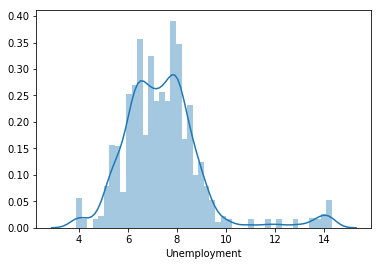

In [15]:
# распределение признака безработица (пропуски значений исключили из графика)
sns.distplot(data.Unemployment.dropna())

              Temperature  Fuel_Price  Unemployment
Temperature      1.000000    0.116232      0.041552
Fuel_Price       0.116232    1.000000      0.019813
Unemployment     0.041552    0.019813      1.000000


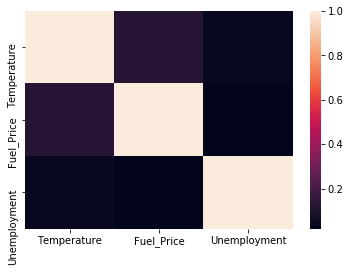

In [16]:
# корреляция количественных признаков
print(data[['Temperature', 'Fuel_Price', 'Unemployment']].corr())
sns.heatmap(data[['Temperature', 'Fuel_Price', 'Unemployment']].corr());

## train.csv и test.csv

Просмотрев данные в train.csv и test.csv видно, что даты (начало отсчета и шаг) совпадают с таблицей data.csv, что позволяет легко сопаставить данные для обучения. 
- Даты в трейне и тесте непрырывны 
- Количество ресторанов в городах в даипозоне от 71 до 79. По описанию городов население может отличаться в несколько раз (максимальная разница ~6 раз). Также видно, что кол-во ресторанов в тестовой выборке меньше либо равно количеству в обучающей. *Возможно стоит попробовать очистить обучающую выборку от ресторанов, выручку которых не нужно предсказывать. В итоге оказалось, что эти данные не лишние, т.к. они хорошо усредняют предсказания для ресторанов, как в следующем пункте.
- В тестовом датасете в некоторых городах необходимо предсказать выручку ресторана, которого нет в обучающей. (например, в 7 городе 99 ресторана в обучающей выборке нет, но есть в тестовой). Необходимо, что в таких случаях модель могла предсказать не 0, а, например, среднее значение по городу. (На самом деле, в моделях основанных на деревьях решений прексказывается среднее значение в листе (лист может содержать минимум 1 пример, но чаще всего там их несколько)).

Для удобства преобразования (чтобы не повторять те же действия) тестовой и обучающей выборок мы можем их объединять, а потом снова разделять.

In [17]:
train = pd.read_csv('train.csv')
train.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday
0,1,1,05-02-10,24924.50,False
1,1,1,12-02-10,46039.49,True
2,1,1,19-02-10,41595.55,False
3,1,1,26-02-10,19403.54,False
4,1,1,05-03-10,21827.90,False


In [18]:
predict = pd.read_csv('test.csv')
predict.head()

,City,Restaurant,Date,IsHoliday
0,1,1,06-01-12,False
1,1,1,13-01-12,False
2,1,1,20-01-12,False
3,1,1,27-01-12,False
4,1,1,03-02-12,False


In [19]:
# проверим даты на совпадение шага с data.csv
train.Date.unique()

array(['05-02-10', '12-02-10', '19-02-10', '26-02-10', '05-03-10',
       '12-03-10', '19-03-10', '26-03-10', '02-04-10', '09-04-10',
       '16-04-10', '23-04-10', '30-04-10', '07-05-10', '14-05-10',
       '21-05-10', '28-05-10', '04-06-10', '11-06-10', '18-06-10',
       '25-06-10', '02-07-10', '09-07-10', '16-07-10', '23-07-10',
       '30-07-10', '06-08-10', '13-08-10', '20-08-10', '27-08-10',
       '03-09-10', '10-09-10', '17-09-10', '24-09-10', '01-10-10',
       '08-10-10', '15-10-10', '22-10-10', '29-10-10', '05-11-10',
       '12-11-10', '19-11-10', '26-11-10', '03-12-10', '10-12-10',
       '17-12-10', '24-12-10', '31-12-10', '07-01-11', '14-01-11',
       '21-01-11', '28-01-11', '04-02-11', '11-02-11', '18-02-11',
       '25-02-11', '04-03-11', '11-03-11', '18-03-11', '25-03-11',
       '01-04-11', '08-04-11', '15-04-11', '22-04-11', '29-04-11',
       '06-05-11', '13-05-11', '20-05-11', '27-05-11', '03-06-11',
       '10-06-11', '17-06-11', '24-06-11', '01-07-11', '08-07-

In [20]:
# проверим даты на совпадение шага с data.csv
predict.Date.unique()

array(['06-01-12', '13-01-12', '20-01-12', '27-01-12', '03-02-12',
       '10-02-12', '17-02-12', '24-02-12', '02-03-12', '09-03-12',
       '16-03-12', '23-03-12', '30-03-12', '06-04-12', '13-04-12',
       '20-04-12', '27-04-12', '04-05-12', '11-05-12', '18-05-12',
       '25-05-12', '01-06-12', '08-06-12', '15-06-12', '22-06-12',
       '29-06-12', '06-07-12', '13-07-12', '20-07-12', '27-07-12',
       '03-08-12', '10-08-12', '17-08-12', '24-08-12', '31-08-12',
       '07-09-12', '14-09-12', '21-09-12', '28-09-12', '05-10-12',
       '12-10-12', '19-10-12', '26-10-12'], dtype=object)

In [21]:
# видим, что среднее значение прибыли в праздничную и непраздничную неделю мало отличается 
#(вероятно, признак будет не сильно значимым)

train.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    17997.496471
True     19436.352405
Name: Weekly_Sales, dtype: float64

# Datasets Transformation

- признак даты мы разделим и создадим отдельный "год", "месяц" и "неделя года". При обучении модели попробуем с номером недели и без, т.к. возможно данный признак только ухудшит предсказание модели.
- полученные категориальные признаки мы преобразуем с помощью onehotencoding (а также попробуем и без него обучить бустинг)
- заполняем значение населения города из файла restaurants.csv. Также заполняем из data.csv значения температуры, безработицы и стоимости топлива по дате и городу, соответственно.
- Т.к. в датасете для обучения есть отрицательные значения целевого признака, значит это не выручка (она не может быть меньше 0), а прибыль. Т.е. выручка с вычетом затрат.
- Попробуем создать дополнительные признаки и посмотрим на качество модели.

## Functions

In [22]:
# ф-ия для преобразования признака даты к новые категориальные признаки

def date_transfrom(df, feature='Date'): 
    df[feature] = pd.to_datetime(df[feature], format='%d-%m-%y') # преобразовываем в формат datetime
    df['year'] = df[feature].dt.year # создаем новый признак год
    df['month'] = df[feature].dt.month # новый признак месяц
#     df['week_of_year'] = df[feature].dt.weekofyear # новый признак порядкой номер недели года
    df = df.drop(feature, axis=1)
    
    return df

In [23]:
# ф-я для OneHotEncoding категориальных признаков датасета 
# используется pd.get_dummies, а не реализация sklearn

def onehotencoding(df, categories):
    for categor in categories:
        df = pd.concat([df, pd.get_dummies(df[categor], prefix=categor)], axis=1)
        
    return df.drop(categories, axis=1)

## Train transform

In [24]:
# отделим целевой признак

y = train.Weekly_Sales
train = train.drop('Weekly_Sales', axis=1)

In [25]:
train = train.merge(cities, on=['City'])

In [26]:
train = train.merge(data[['City', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment']], on=['City', 'Date'])

In [27]:
# преобразуем дату 
train = date_transfrom(train)

In [28]:
# т.к. модели не смогут итрерпретировать True и False преобразуем в числовоые значени
train['IsHoliday'] = train.IsHoliday.map({True : 1, False : 0})

## Test transform

In [29]:
# заполняем значение Size для городов

predict = predict.merge(cities, on=['City'])

In [30]:
# заполняем значения для температуры, стоимости топлива и уровня безработицы

predict = predict.merge(data[['City', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment']], on=['City', 'Date'])

In [31]:
# преобразуем дату 
predict = date_transfrom(predict)

In [32]:
# т.к. модели не смогут итрерпретировать True и False преобразуем в числовоые значени
predict['IsHoliday'] = predict.IsHoliday.map({True : 1, False : 0})

## OneHotEncoding (concatenate train and test) OPTINAL

Закамментировано, т.к. в итоге по уровню точности моделей отказались от данного преобразования

In [33]:
 # объеденяем две выборки, чтобы уникальные значение категорий были в обоих выборках

# categorical_features = ['City', 'Restaurant', 'year', 'month']

# concat = pd.concat([train, predict])
# concat = onehotencoding(concat, categorical_features)

# train = concat[:train.shape[0]]
# predict = concat[train.shape[0]:]

## Feature Engineering

In [34]:
# новый признак - количественный - платежеспособное население 
# делим на 100, т.к. уровень считается в %

train['Payable'] = train.size * train.Unemployment / 100
predict['Payable'] = predict.size * predict.Unemployment / 100

In [35]:
# новый признак - бинарный - теплее или холоднее 15 градусов по цельсию
# пороговое значение взято из дерева решений (код построение дерева опустил)

# train['warm'] = (train.Temperature < 60).map({False : 0, True : 1})
# predict['warm'] = (predict.Temperature < 60).map({False : 0, True : 1})

# признак показал ухудшение качества модели

In [36]:
# новый признак - категориальный - размер города
# 1 - до 100 тыс, 2 - до 200, 3 - более 200


In [37]:
# новый признак - бинарный - цены на топливо (вершина 1 и 2)
# на графике распределения признака хорошо виден порог ~3.2


In [38]:
# dataset default sorted by Date, so we just split on train/valid
# split thresholder = 110350. This's 80% to train and 20% to valid

thres = 110350

X_train, X_valid = train[:thres], train[thres:]
y_train, y_valid = y[:thres], y[thres:]


# Model Selection

В данном пункте мы проверим качество базовых моделей и отберем лучшие для настройки параметров

## Models

In [39]:
# отображаем значимость признаков в модели
# рисуем график предсказаний модели в сравнении с действительным значением

def draw(estimator, name):
    pred = pd.DataFrame(estimator.predict(X_valid))
    plt.figure(figsize=(25,10))
    sns.lineplot(range(y_valid.shape[0]), y_valid)
    sns.lineplot(range(y_valid.shape[0]), pred.values.T[0])
    plt.title(name)
    
    print('MAE:', mean_absolute_error(y_valid, estimator.predict(X_valid)))     
    print('RMSE:', np.sqrt(mean_squared_error(y_valid, estimator.predict(X_valid))))
    
    try:
        print(sorted(dict(zip(train.columns, estimator.feature_importances_)).items(), key=lambda x: x[1], reverse=True))
    except:
        print("This model doesn't have FeatureImportance")

### LinearRegressor

MAE: 16226.262045987023
RMSE: 24865.319583912293
This model doesn't have FeatureImportance


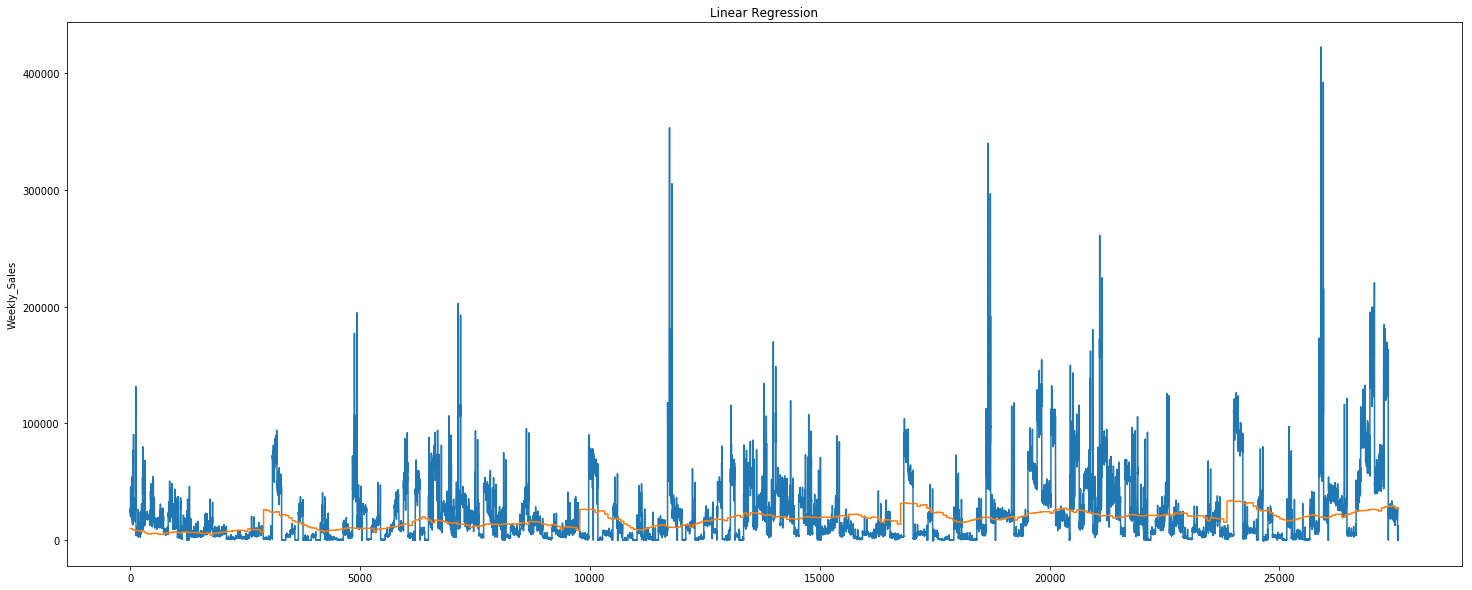

In [40]:
linear = LinearRegression()
linear.fit(X_train, y_train)
draw(linear, "Linear Regression")

### AdaBoostRegressor 

MAE: 24445.66089162051
RMSE: 30957.437872249742
[('Temperature', 0.3996222282725851), ('Restaurant', 0.2176856203044092), ('Size', 0.1331732308733647), ('month', 0.09012180672089196), ('Fuel_Price', 0.0875767297998227), ('Unemployment', 0.04200844889643918), ('Payable', 0.023948934020439294), ('City', 0.0040602353117204755), ('year', 0.0018027658003275423), ('IsHoliday', 0.0)]


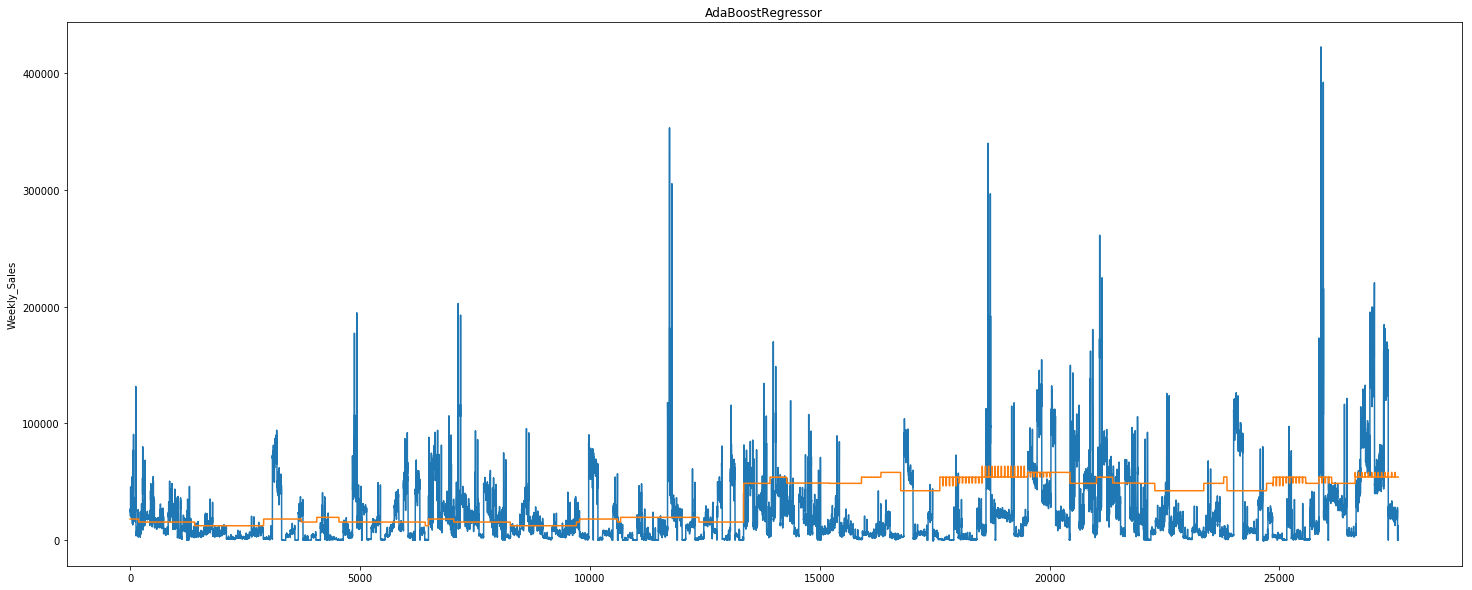

In [41]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

draw(ada, 'AdaBoostRegressor')

### ExtraTreesRegressor

MAE: 13850.42719417863
RMSE: 21831.455224811052
[('Restaurant', 0.2110314850689799), ('month', 0.20217649261594914), ('Fuel_Price', 0.191689435429306), ('Temperature', 0.13772008236256594), ('Size', 0.09933105492189306), ('Unemployment', 0.060121750094723245), ('Payable', 0.039259559100268585), ('City', 0.02373641400054502), ('year', 0.020471981684668395), ('IsHoliday', 0.014461744721100758)]


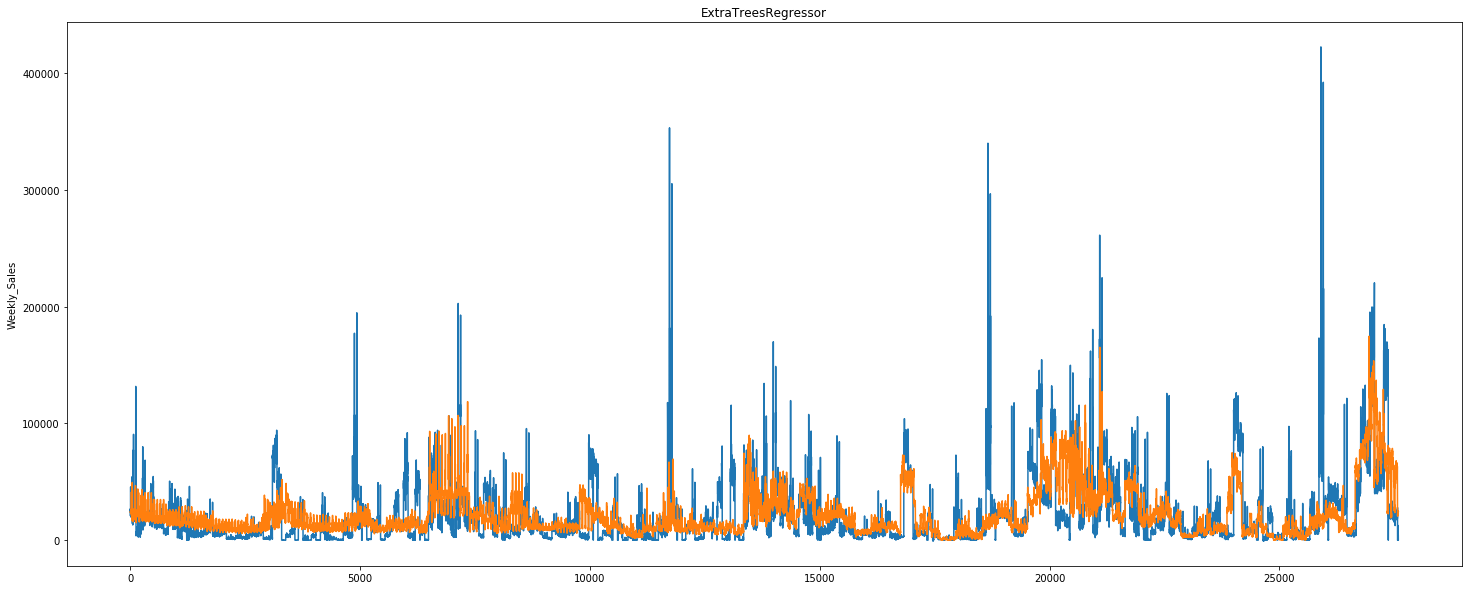

In [42]:
extra = ExtraTreesRegressor()
extra.fit(X_train, y_train)

draw(extra, 'ExtraTreesRegressor')

### GradientBoostingRegressor

MAE: 14450.059711977388
RMSE: 22114.594147359243
[('Fuel_Price', 0.27815675778922894), ('Temperature', 0.1828788110547851), ('month', 0.17379121998552272), ('Size', 0.1370920388619442), ('Unemployment', 0.09314855653480487), ('Payable', 0.06730075931783394), ('City', 0.027460813076358212), ('IsHoliday', 0.013848139375845094), ('year', 0.013425844318776074), ('Restaurant', 0.012897059684900656)]


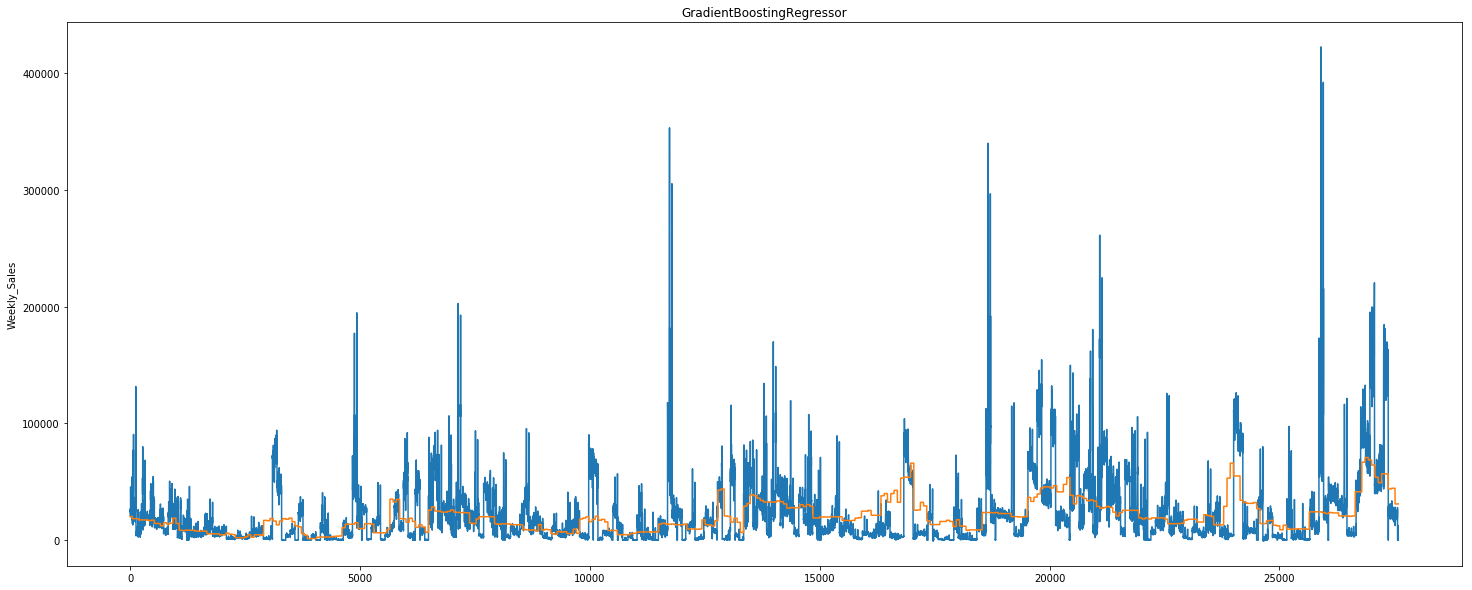

In [43]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

draw(gbr, 'GradientBoostingRegressor')

### RandomForestRegressor

MAE: 14877.290207046542
RMSE: 24443.532861494263
[('Fuel_Price', 0.275368772998044), ('month', 0.18945077928897197), ('Restaurant', 0.15734662265294885), ('Temperature', 0.127013333109326), ('Size', 0.1163538379374726), ('Unemployment', 0.053256776430967066), ('Payable', 0.03456140560798913), ('City', 0.03196982422946958), ('IsHoliday', 0.013195355896557594), ('year', 0.001483291848253189)]


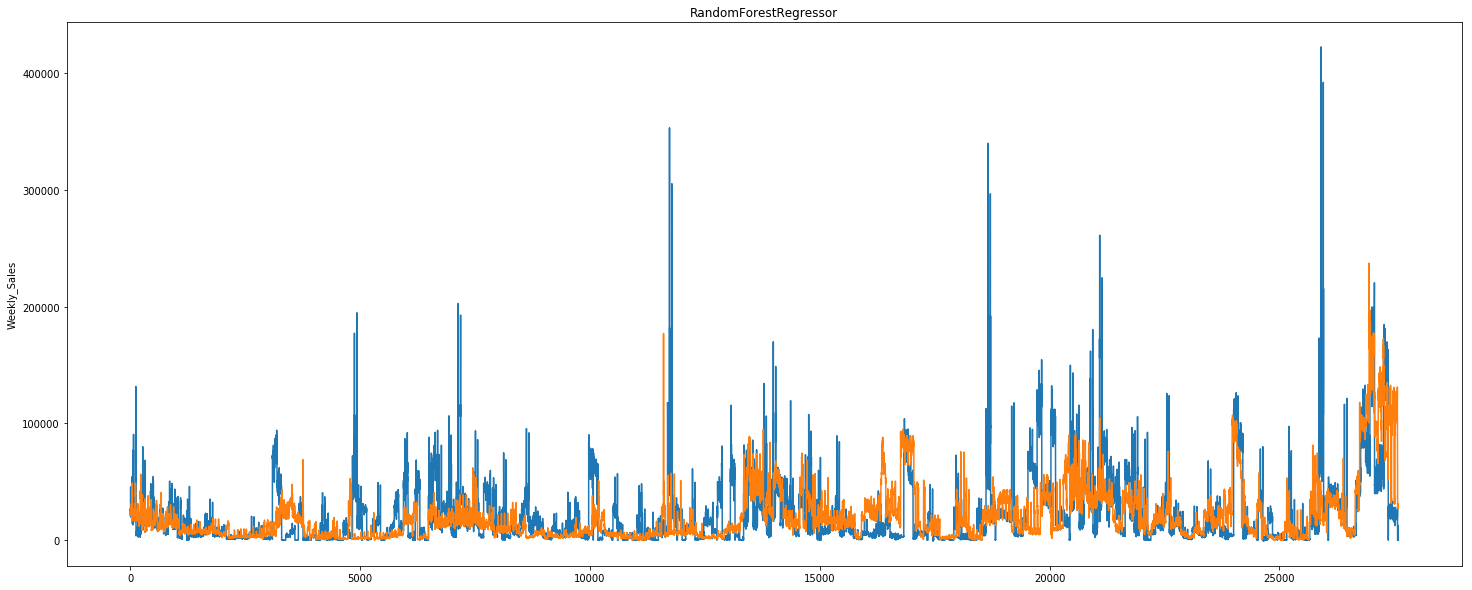

In [44]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

draw(forest, 'RandomForestRegressor')

### XGBoostRegressor

[13:37:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 14469.186252540521
RMSE: 22127.878106162458
[('Size', 0.32842106), ('Unemployment', 0.1609632), ('month', 0.15694849), ('Fuel_Price', 0.14754562), ('Temperature', 0.072565235), ('City', 0.062089246), ('IsHoliday', 0.057952717), ('Restaurant', 0.0135145), ('year', 0.0), ('Payable', 0.0)]


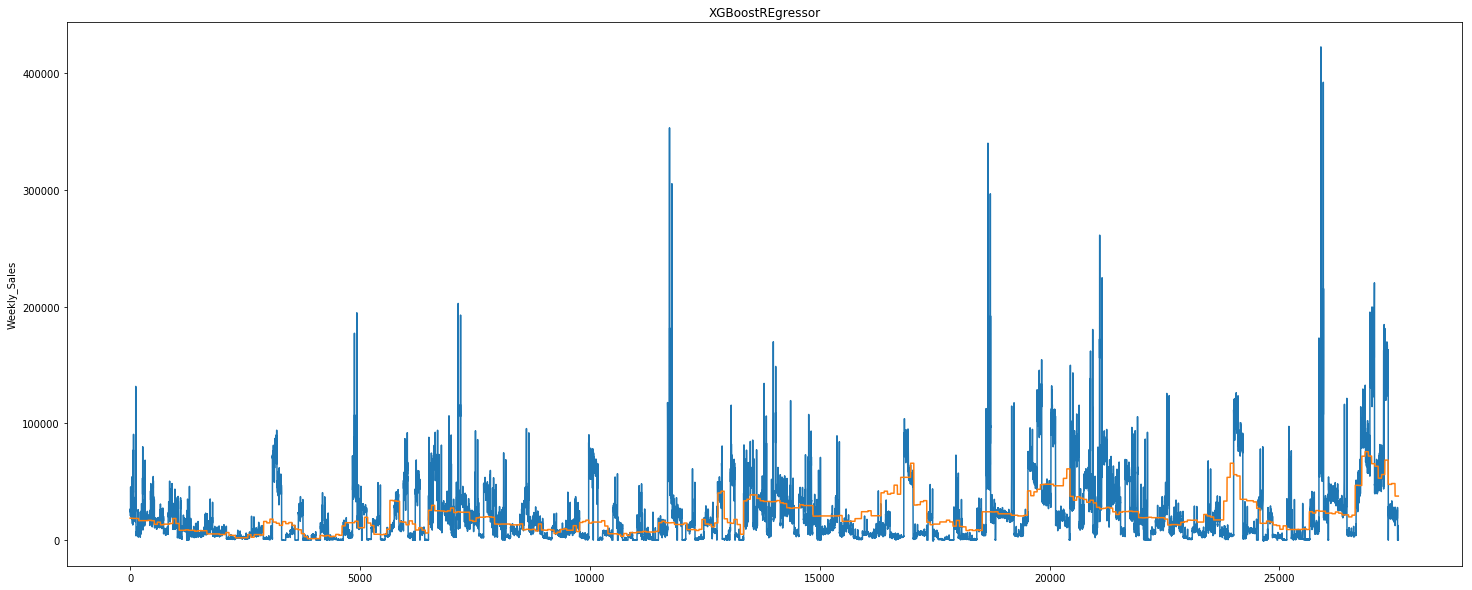

In [45]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

draw(xgbr, 'XGBoostREgressor')

### CatBoostRegressor

MAE: 13369.031921647393
RMSE: 20603.50862852605
[('Fuel_Price', 30.057201553589383), ('month', 20.731492946992915), ('Size', 18.223772282021827), ('Temperature', 13.058269452690476), ('Unemployment', 5.1984041666056875), ('Payable', 4.818298182485758), ('City', 4.158221481527675), ('Restaurant', 2.321744870781529), ('IsHoliday', 1.0115771556490722), ('year', 0.42101790765567954)]


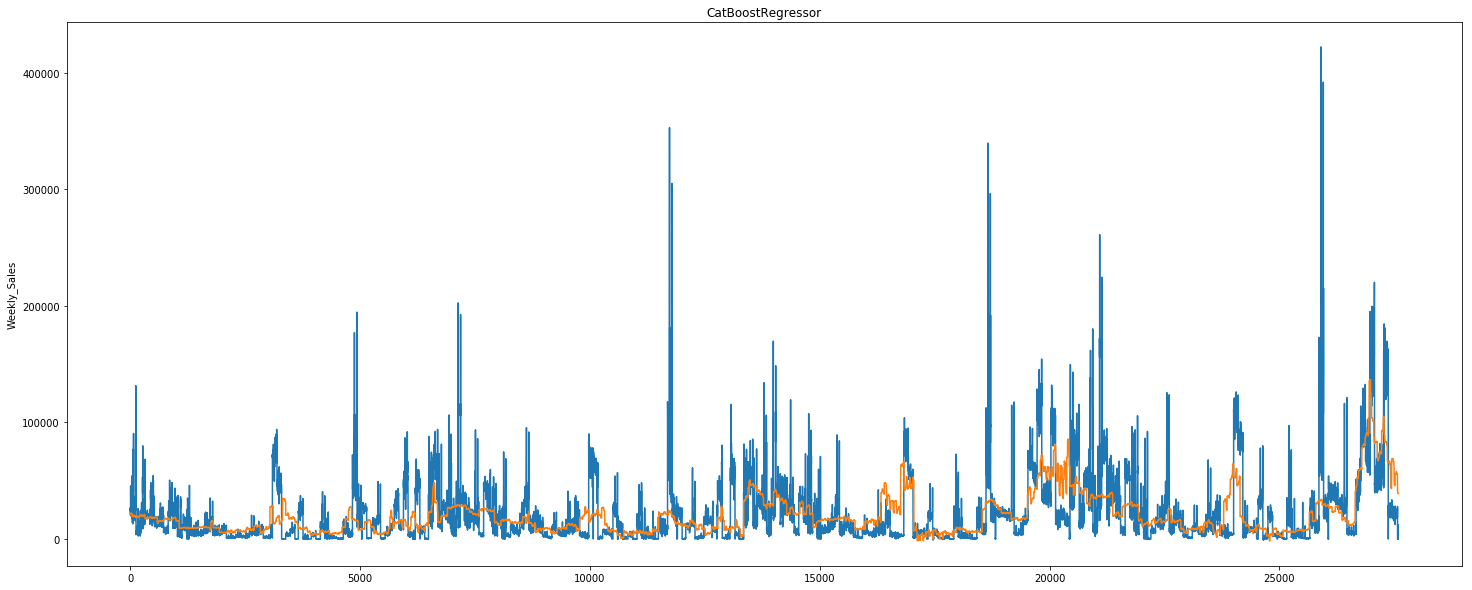

In [46]:
cbr = CatBoostRegressor()
cbr.fit(X_train, y_train, silent=True)

draw(cbr, 'CatBoostRegressor')

### Conclusions

- Линейные модели работают плохо в данной задаче из-за того, что основная масса признаков - категориальная. Модель LinearRegression исключаем.
- AdaBoost мы также исключаем т.к. ошибка данной модели значительно выше остальных.
- Оставшиеся модели будем пробовать тюнинговать (подбирать параметры). Стоит отметить, что выбранные модели основаны на деревьях решений, что объясняет их похожие результаты. На самом деле, можно было сразу исключить линейные модели, но все решил их добавить для обоснованности решения.
- Помимо тюнинга моделей, будем также пробовать разные комбинации признаков (например, зачастую признак "номер недели года" ухудшает качество модели. *Обучил модель с данным признаком - результат хуже, поэтому закомментировал сроку добавления этого признака). Признак год также для модели бессполезный, но сохраним его для наглядности графика в конце предсказаний.
- Видно, что все модели очень маленький вес назначают признакам год, стоимости топлива и температуре. Возможно их в будущем исключим, если качество без них не станет хуже. Но пока что рано делать выводы, переходим к тюнингу выбранных моделей.


## RandomSearchCV

- Будем использовать рандомный поиск по сетке, т.к. на перебор (gridserarch) уйдет очень много времени
- В данном ноутбуке не будет заметно, но в случае если параметр будет выбран из крайнего значения диапазона я его расширю, и сделаю шаг меньше в окрестностях выбранного значения, чтобы найти лучшее значение для модели.
- Оценка качества в нашем случае это значение функции ошибки, которую мы минимизируем. Также графики позволяют наглядно увидеть предсказание модели. Т.к. это сеть ресторанов, важно посмотреть на реальную и предсказанную суммы прибыли.

In [47]:
# отображаем значимость признаков в модели
# рисуем график предсказаний модели в сравнении с действительным значением

def draw_cv(estimator, name):
    pred = pd.DataFrame(estimator.predict(X_valid))
    plt.figure(figsize=(25,10))
    sns.lineplot(range(y_valid.shape[0]), y_valid)
    sns.lineplot(range(y_valid.shape[0]), pred.values.T[0])
    plt.title(name)
    
    print('MAE:', mean_absolute_error(y_valid, estimator.predict(X_valid)))     
    print('RMSE:', np.sqrt(mean_squared_error(y_valid, estimator.predict(X_valid))))
    
    print(estimator)
    
    try:
        print(sorted(dict(zip(X_train.drop(drops, axis=1).columns, estimator.feature_importances_)).items(), key=lambda x: x[1], reverse=True))
    except:
        print("This model doesn't have FeatureImportance")

### ExtraTrees

MAE: 15176.561237557535
RMSE: 22463.182432863898
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=70,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=4, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
This model doesn't have FeatureImportance


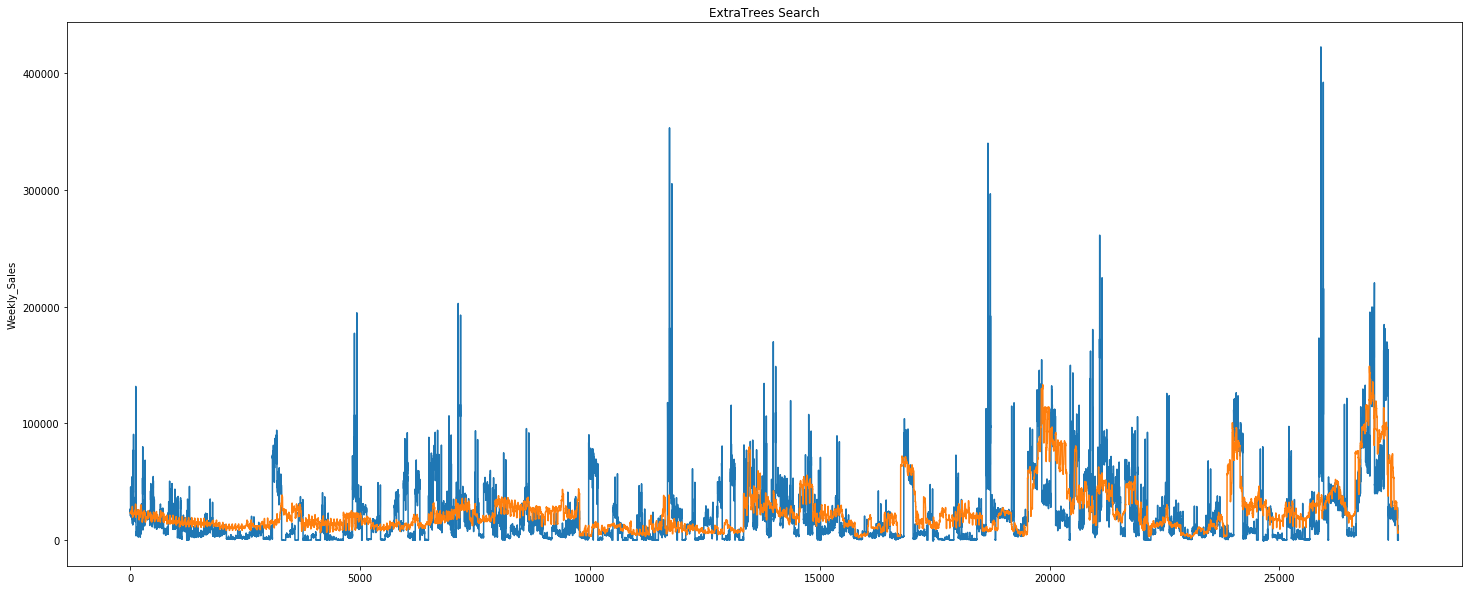

In [48]:
params = {
    'n_estimators' : [10, 35, 50, 70, 100, 200],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
    'n_jobs' : [-1]
}

extra_cv = RandomizedSearchCV(ExtraTreesRegressor(), params, scoring='neg_mean_absolute_error')
extra_cv.fit(X_train, y_train)

draw_cv(extra_cv.best_estimator_, 'ExtraTrees Search')

### RandomForest

MAE: 13716.766272870764
RMSE: 21916.15416001267
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=75,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
This model doesn't have FeatureImportance


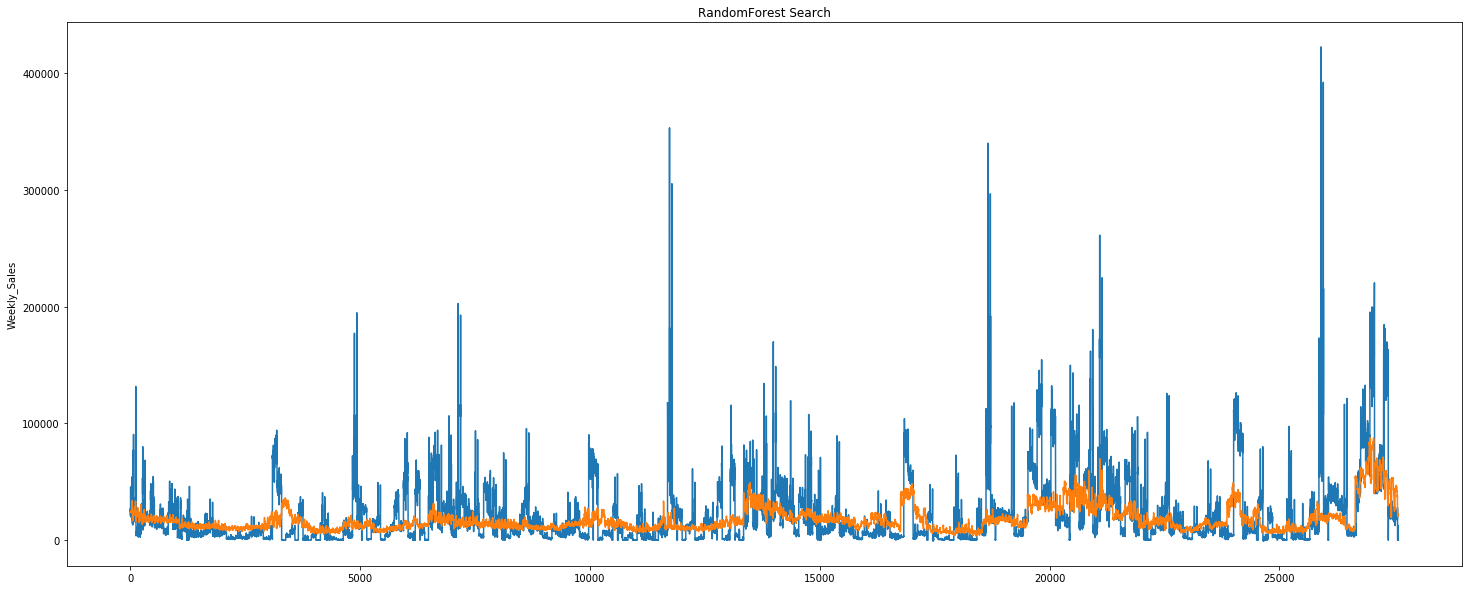

In [49]:
params = {
    'n_estimators' : [40, 50, 60],
     'max_depth': [ 45, 50, 55, 60, 65, 70, 75, None],
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': list(range(3, 8)),
    'bootstrap' : [True, False],
    'n_jobs' : [-1]
}

forest_cv = RandomizedSearchCV( RandomForestRegressor(), params)
forest_cv.fit(X_train, y_train)

draw_cv(forest_cv.best_estimator_, 'RandomForest Search')

### GradientBoosting

MAE: 15854.78068396784
RMSE: 22633.866101810527
GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
             learning_rate=0.25, loss='ls', max_depth=2,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
This model doesn't have FeatureImportance


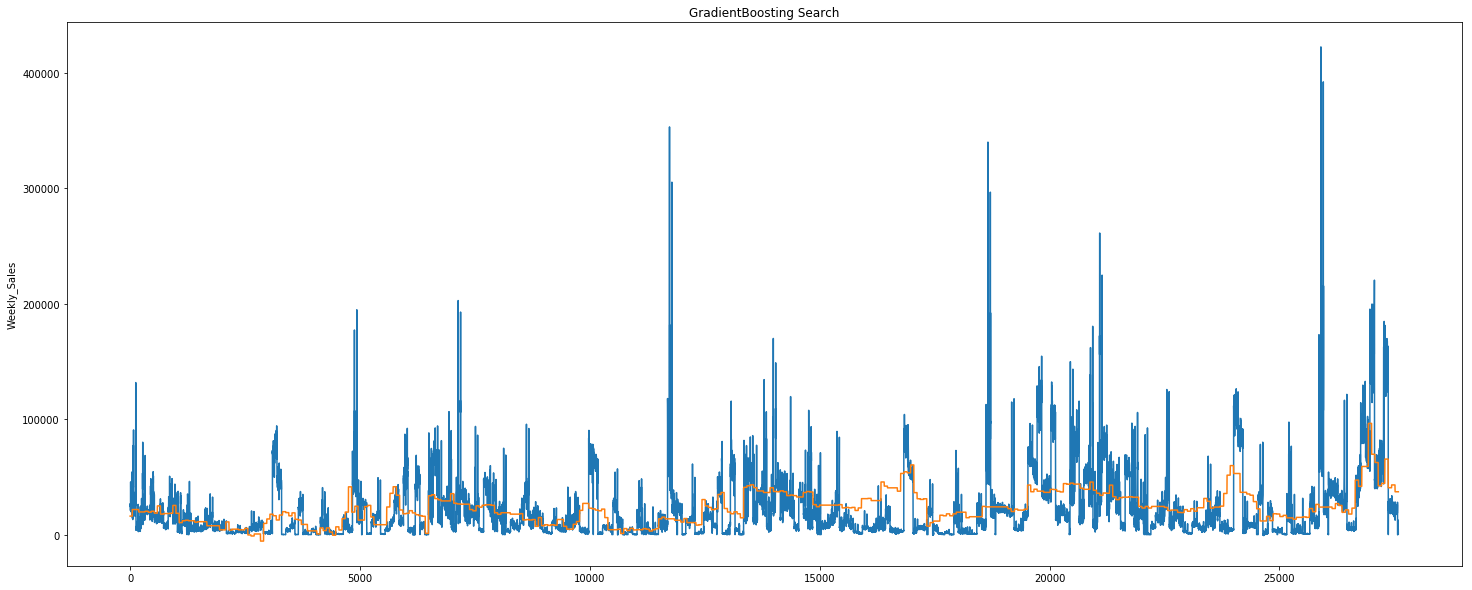

In [50]:
params = {
    'alpha' : [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9],
    'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800],
     'max_depth': [2, 3, 4, 5, 7, 10],
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': [2, 4, 6, 8, 10, 12, 15],
     'min_samples_split': [2, 4, 5, 7, 10],
    'learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5]
}

gbr_cv = RandomizedSearchCV(GradientBoostingRegressor(), params)
gbr_cv.fit(X_train, y_train)

draw_cv(gbr_cv.best_estimator_, 'GradientBoosting Search')

### XGBoost

[13:46:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:47:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:48:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:42] WARNI

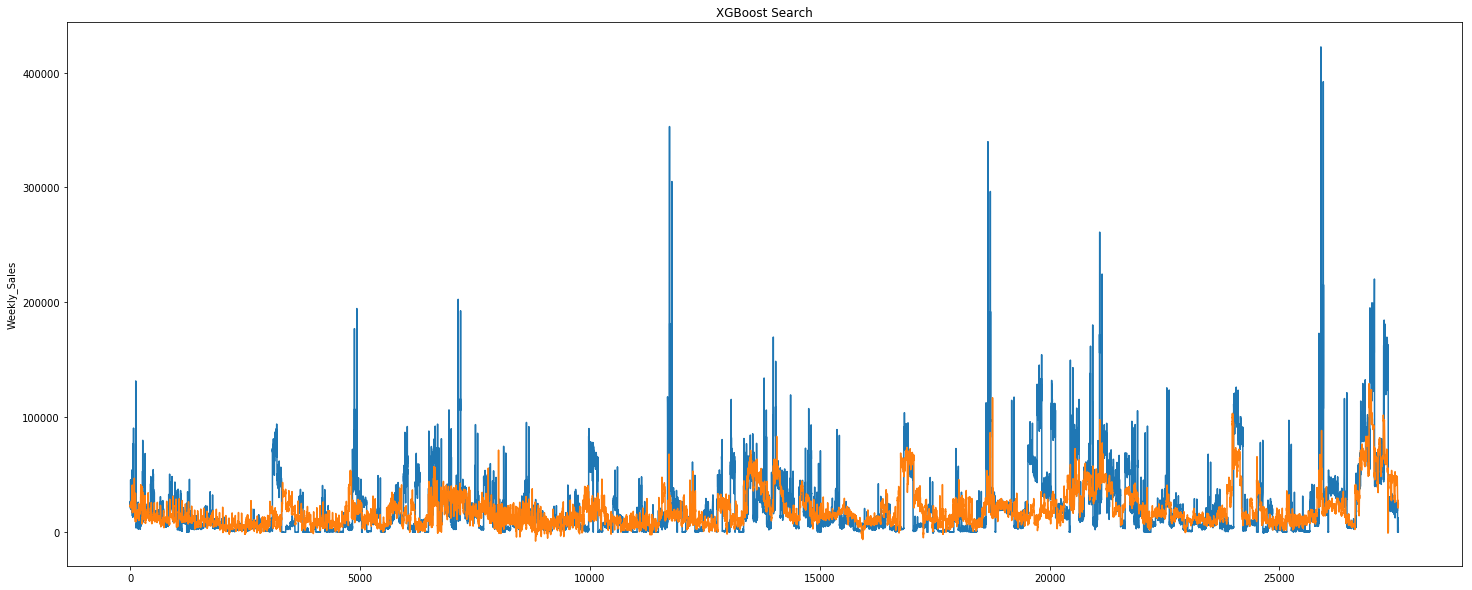

In [51]:
params = {
        'alpha' : [0.03, 0.04, 0.05, 0.06, 0.07],
        'eta' : list(np.arange(0.3, 0.4, 0.02)),
        'n_estimators' : [600, 700, 800, 900],
        'min_child_weight': [1, 5, 10],
        'gamma': list(np.arange(1.5, 2.5, 0.02)),
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'max_depth': [9, 10, 11]
        }

xgbr_cv = RandomizedSearchCV(XGBRegressor(), params)
xgbr_cv.fit(X_train, y_train)

draw_cv(xgbr_cv.best_estimator_, 'XGBoost Search')

### CatBoost Search

In [65]:
params = {
        'n_estimators' : list(range(800, 1500, 200)),
        'learning_rate': list(np.arange(0.05, 0.51, 0.05)),
        'depth': list(range(2, 15, 2)),
        'l2_leaf_reg': list(range(7, 13))
}

cbr_cv = RandomizedSearchCV(CatBoostRegressor(), params)
cbr_cv.fit(X_train, y_train, silent=True)
draw_cv(cbr_cv.best_estimator_, 'CatBoost Search')

KeyboardInterrupt: 

### Conclusions

Попробовав найти оптимальные гиперпараметры для моделей, мы остановимся на CatBoost для предсказаний. 
- Минимальная ошибка MAE: 6245.95. 
- Разница сумм состовляет 5%.
- Графики распределения реальной прибыли и предсказанной очень похожи.
- Мат.ожидание, стандартное отклонение, минимальное и максимальные значения реальной и предсказанной выборок очень похожи. 

Все эти наблюдения доказывают состоятельность выбранной модели. (конечно разумно было бы сравнивать модели строя доверительный интервал разницы их ошибки, но там скорее всего бы интрвале был 0, поэтому утверждать что какая-то модель из выбранных для кросс-валидации лучше другой нельзя.)

In [53]:
# сохраним отдельно лучшую модель

best_model = cbr_cv.best_estimator_

In [54]:
# т.к.  минимальное значение в обучающей выборке -1098, поэтому все значения меньшие этого порога заменим на него.

check = pd.Series(cbr_cv.best_estimator_.predict(X_valid))
check = check.where(check>-1098, -1098)

In [55]:
# сравним сумму реальной прибыли, предсказанной и 

print('Реальная прибыль:', sum(y_valid))
print('Предсказанная прибыль:', sum(check))
print('Разница в %:', (sum(check) - sum(y_valid)) / sum(y_valid))

Реальная прибыль: 546794368.0799986
Предсказанная прибыль: 495081000.52847755
Разница в %: -0.0945755307120412


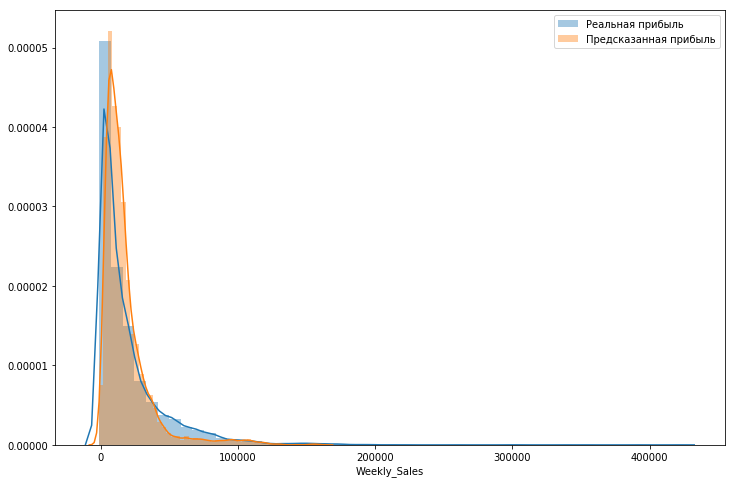

In [56]:
# построим график распределения реальной прибыли и предсказанной
plt.figure(figsize=(12,8))

sns.distplot(y_valid)
sns.distplot(check)
plt.legend(['Реальная прибыль', 'Предсказанная прибыль']);

In [57]:
# сравним параметры выборок реальной прибыли и предсказанной

pd.DataFrame(np.array([y_valid, round(check, 2)]).T, columns=['Real', 'Predicted']).describe()

,Real,Predicted
count,27588.000000,27588.000000
mean,19820.007542,17945.519792
std,26114.956305,18346.951031
min,-798.000000,-1098.000000
25%,3674.252500,7263.312500
50%,10359.075000,12931.855000
75%,24991.157500,21254.620000
max,422306.250000,161939.470000


In [58]:
# посмотрим на все значения более детально

pd.DataFrame(np.array([y_valid, round(check, 2)]).T, columns=['Real', 'Predicted'])

,Real,Predicted
0,24478.42,21072.59
1,26767.86,20887.01
2,26479.47,20982.64
3,25632.20,20972.98
4,26116.90,20764.13
...,...,...
27583,12550.00,56974.64
27584,1645.00,55985.48
27585,4870.00,56187.04
27586,4420.00,56197.46


# Applying Selected Model

1. Выбранную модель необходимо переобучить на всей обучающей выборке (без разделения на валидационную часть)
2. Сделать предсказание на тестовой выборке
3. Проверить распределение предсказанных значений
4. Построить график суммарных доходов по месяцам за весь период (объеденить тестовую и обучающую выборки)

In [59]:
# обучаем модель на всей обучающей выборке и предсказываем значения

best_model.fit(train, y, silent=True)
result = best_model.predict(predict)

In [60]:
# добавляем в выборки целевой признак

train['Weekly_Sales'] = y
predict['Weekly_Sales'] = result

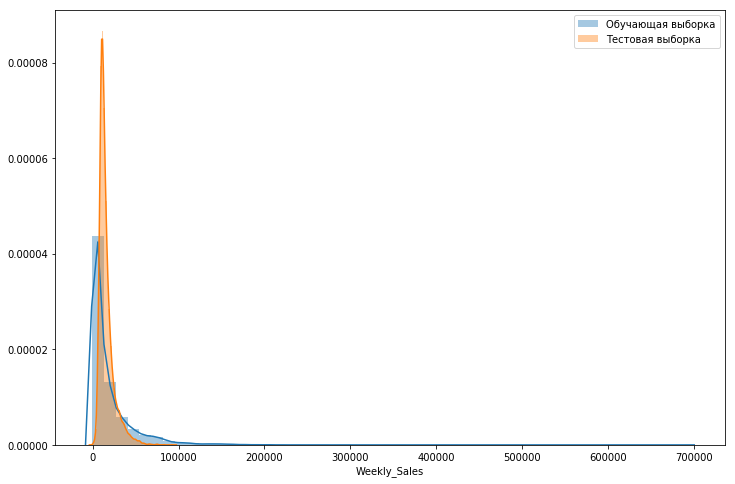

In [61]:
plt.figure(figsize=(12,8))

sns.distplot(y)
sns.distplot(result)

plt.legend(['Обучающая выборка', 'Тестовая выборка']);

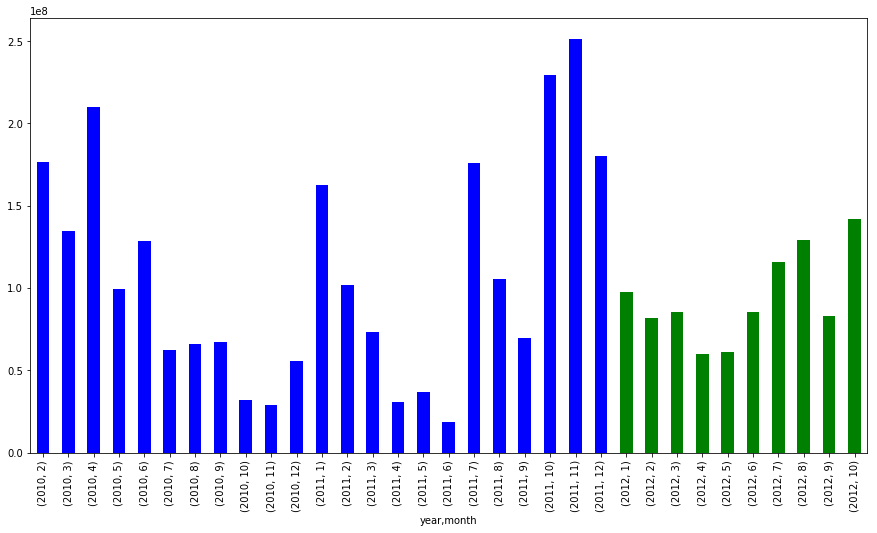

In [62]:
# график сумму прибыли всех ресторанов по месяцам
# зеленым цветом отмечены предсказанные месяцы

plt.figure(figsize=(15, 8))
pd.concat([train, predict]).groupby(['year', 'month'])['Weekly_Sales'].sum().plot.bar(color=['b'] * 23 + ['g'] * 10);

# Write Result Down

Запишем предсказанные значения в файл как указано в условии задачи.

In [63]:
def write_result(weekly_sales):
    file = pd.read_csv('test.csv')
    file['Weekly_Sales'] = np.round(weekly_sales, 2)

    file.to_csv('test_predicted.csv', index=False)
        
write_result(result)

# Conclusion

- График распределения, график суммы по месяцам, характеристики распределения (мат. ожидание, стандартное отклонение, персентили) подтверждают состоятельность модели.
- Т.к. деревья решений берут среднее значение в листе, то повторять выбросы (экстремально высокие значения целевого признака) получается далеко не всегда.
- Тренды роста прибыли за 2 года в обучающей выборке выявлены не были, собственно, модель сохранила стабильность, но роста также не показала.
- Признак стоимости топлива (хоть и имеет некий вес в моделе) все же даже логически сложно связать с выручкой сети ресторанов, и правильным было бы его исключить. *Я его оставил только из предположения, что стоимость топлива может отображать динамику покупательской способности населения во времени.
- Т.к. время все же ограничего не успел попробовать сгенерировать новые признаки (поэтому в 3.5 только комменты, как TODO list) и проверить качество модели на них.
- Также при наличии времени нужно было попробовать итеративный подход обучения предсказания (хотя из-за большого кол-ва ресторанов мог не сработать). Т.е. пресказать на первых несколько недель, переобучить модель добавив в обучающую выборку предсказание на предыдущей итерации и т.д.
- Из-за наличия отрицательных значений целевого признака не удалось преобразовать к более "нормальному" распределению (например, через взятие лагорифма)\
- Не использовал RandomState, поэтому воспроизводимость результатов будет почти одинаковая, но не точная.